# Analysis of Scientific Articles

## 1. Initial Data Exploration

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_excel('../data/df_articles_results.xlsx')

# Total number of articles
num_articles = len(df)
print(f'Total number of articles: {num_articles}')

# Number of included and excluded articles
inclusion_counts = df['GlobalInclusion'].value_counts()
print(inclusion_counts)

Total number of articles: 4039
GlobalInclusion
No         3753
Yes         170
Unclear     116
Name: count, dtype: int64


## 2. Visualizations

### 2.1 Number of Articles by Study Type

Classified file found. Loading data without querying LMStudio...


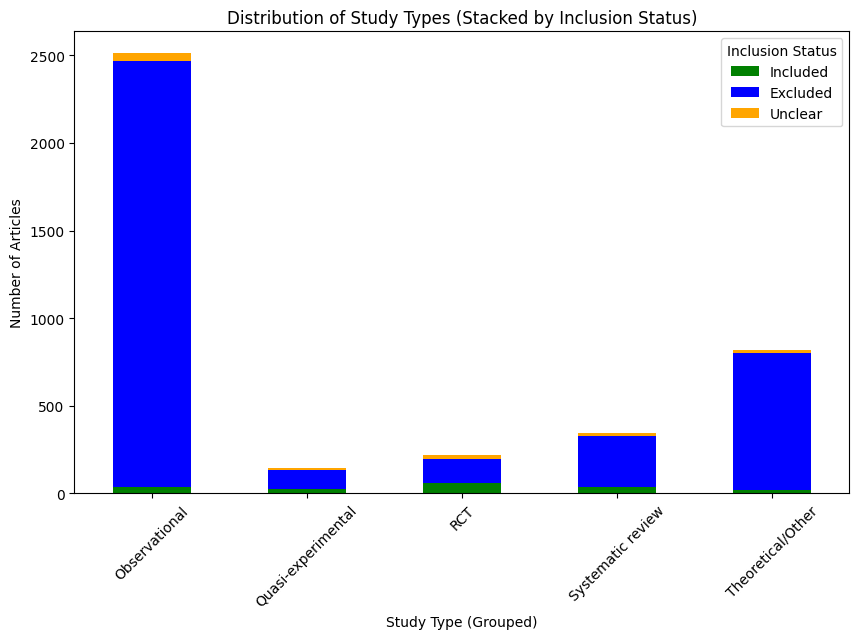

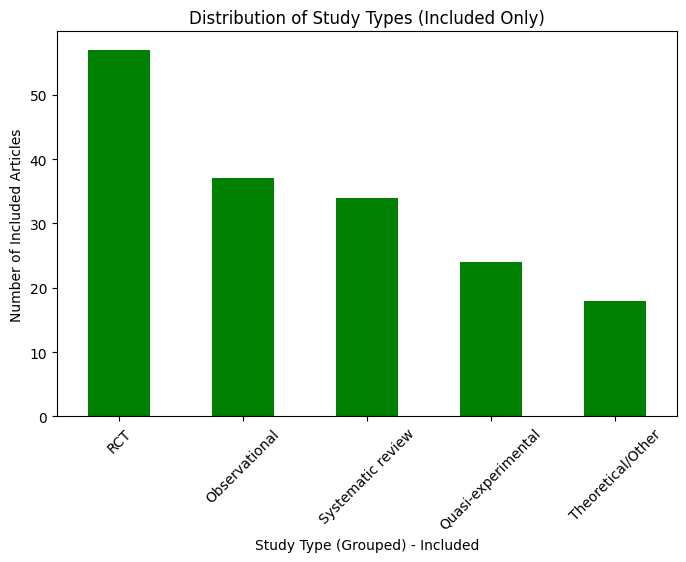

In [12]:
import requests
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paths dels fitxers
data_path = "../data/"
classified_file = os.path.join(data_path, "df_articles_results_classified.xlsx")
original_file = os.path.join(data_path, "df_articles_results.xlsx")

# Comprovar si el fitxer classificat ja existeix
if os.path.exists(classified_file):
    print("Classified file found. Loading data without querying LMStudio...")
    df = pd.read_excel(classified_file)
else:
    print("Classified file not found. Querying LMStudio to classify studies...")
    
    # Carregar dades
    df = pd.read_excel(original_file)

    # Funció per consultar LMStudio
    def consult_model(model_name, article_text):
        url = "http://127.0.0.1:1234/v1/chat/completions"
        
        prompt = (
            "You are a research assistant specialized in systematic reviews.\n\n"
            "Task:\n"
            "Classify the following study into one of these 5 categories:\n"
            "- \"RCT\" (Randomized Controlled Trial)\n"
            "- \"Quasi-experimental\" (Non-randomized studies with a control group)\n"
            "- \"Systematic review\" (Systematic review or meta-analysis)\n"
            "- \"Observational\" (Cohort studies, case-control, cross-sectional)\n"
            "- \"Theoretical/Other\" (Conceptual, methodological, or narrative review)\n\n"
            "Important: Output must be a JSON with this structure:\n"
            "{ \"study_design\": \"CATEGORY\" }\n\n"
            "Article title and abstract:\n"
            f"{article_text}\n\n"
            "Very Important: Output only a JSON object with no additional text."
        )

        request_body = {
            "model": model_name,
            "messages": [
                {"role": "system", "content": "You are an expert in academic article review."},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.0,
            "max_tokens": 100
        }

        try:
            response = requests.post(url, json=request_body, headers={"Content-Type": "application/json"})
            response_text = response.text
            response_json = json.loads(response_text)
            generated_text = response_json["choices"][0]["message"]["content"]
            cleaned_text = generated_text.replace("```json", "").replace("```", "").strip()
            parsed_result = json.loads(cleaned_text)
            return parsed_result.get("study_design", "Uncategorized")
        except Exception as e:
            print(f"Error processing article: {e}")
            return "Uncategorized"

    # Aplicar LMStudio a cada estudi per obtenir la nova classificació
    df["Grouped_Study_Design"] = df["Article Title"].apply(lambda x: consult_model("mistral-small-24b-instruct-2501", x))

    # Guardar el nou dataset amb la classificació
    df.to_excel(classified_file, index=False)

# Normalitzar valors de GlobalInclusion per assegurar consistència
df["GlobalInclusion"] = df["GlobalInclusion"].astype(str).str.strip()

# Comptar les categories per a cada estat d'inclusió
df_pivot = df.pivot_table(index="Grouped_Study_Design", columns="GlobalInclusion", aggfunc="size", fill_value=0)

# Ordenar les columnes perquè l'acumulació sigui coherent
df_pivot = df_pivot.reindex(columns=["Yes", "No", "Unclear"], fill_value=0)

# Generar gràfic de barres apilades
ax = df_pivot.plot(kind="bar", stacked=True, figsize=(10,6), color=["green", "blue", "orange"])
plt.xlabel("Study Type (Grouped)")
plt.ylabel("Number of Articles")
plt.title("Distribution of Study Types (Stacked by Inclusion Status)")
plt.xticks(rotation=45)
plt.legend(title="Inclusion Status", labels=["Included", "Excluded", "Unclear"])
plt.show()

# Filtrar només els estudis inclosos
included_df = df[df["GlobalInclusion"] == "Yes"]

# Comprovar si hi ha estudis inclosos abans de generar el gràfic
if not included_df.empty:
    included_grouped_counts = included_df["Grouped_Study_Design"].value_counts()
    plt.figure(figsize=(8,5))
    included_grouped_counts.plot(kind="bar", color="green")
    plt.xlabel("Study Type (Grouped) - Included")
    plt.ylabel("Number of Included Articles")
    plt.title("Distribution of Study Types (Included Only)")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No included studies found. Skipping the included-only plot.")

### 2.2 Inclusion Proportion

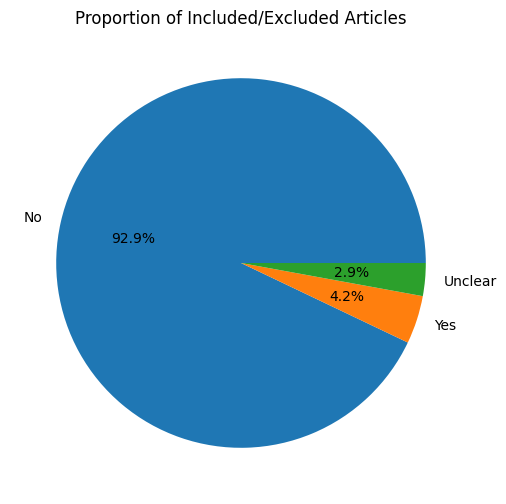

In [13]:
# Pie chart
plt.figure(figsize=(6,6))
inclusion_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title("Proportion of Included/Excluded Articles")
plt.ylabel('')
plt.show()

## 3. Analysis of Model Agreement

### 3.1 Overall Agreement

We compared the classification outputs of four models—Mistral, Qwen, Phi, and Llama—by computing two complementary pairwise metrics across the entire dataset. First, the overall agreement was calculated as the percentage of articles where two models assigned the same classification label. This provides a straightforward measure of agreement. Second, we computed the weighted Cohen’s kappa using quadratic weights, which adjusts for chance agreement and penalizes larger discrepancies between categories more heavily. This approach yields a chance-corrected measure of inter-model agreement. The results are visualized using two side-by-side heatmaps, with one displaying the overall agreement (in blue tones) and the other showing the weighted Cohen’s kappa (in green tones).

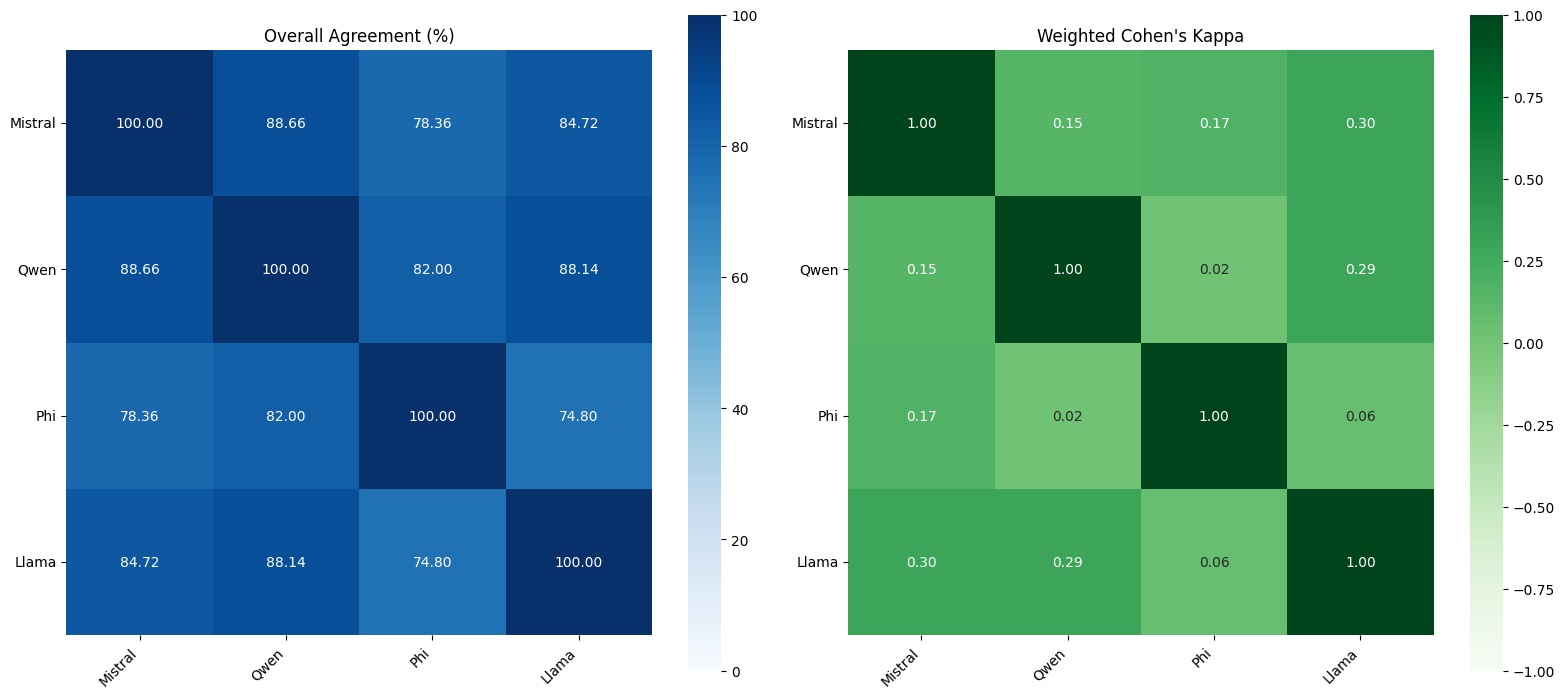

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score

# Full model names and display names mapping
full_model_names = {
    "mistral.small.24b.instruct.2501_inclusion": "mistral.small.24b.instruct.2501",
    "qwen2.5.7b.instruct.1m_inclusion": "qwen2.5.7b.instruct.1m",
    "phi.3.mini.4k.instruct_inclusion": "phi.3.mini.4k.instruct",
    "llama.3.2.3b.instruct_inclusion": "llama.3.2.3b.instruct"
}

display_names = {
    "mistral.small.24b.instruct.2501_inclusion": "Mistral",
    "qwen2.5.7b.instruct.1m_inclusion": "Qwen",
    "phi.3.mini.4k.instruct_inclusion": "Phi",
    "llama.3.2.3b.instruct_inclusion": "Llama"
}

# List of models to be used
models = list(full_model_names.keys())

# Normalize the data: convert to string, remove extra spaces, and convert to lowercase
df[models] = df[models].astype(str).apply(lambda x: x.str.strip().str.lower())

# Initialize matrices for overall agreement (%) and weighted Cohen's kappa
n_models = len(models)
overall_agreement = pd.DataFrame(np.zeros((n_models, n_models)), index=models, columns=models)
weighted_kappa_matrix = pd.DataFrame(np.zeros((n_models, n_models)), index=models, columns=models)

# Calculate pairwise overall agreement and weighted kappa for each pair of models
for i, model_i in enumerate(models):
    for j, model_j in enumerate(models):
        # Overall agreement: percentage of articles where both models agree
        agreement_pct = 100 * (df[model_i] == df[model_j]).sum() / len(df)
        overall_agreement.loc[model_i, model_j] = agreement_pct
        
        # Weighted Cohen's kappa using quadratic weights
        weighted_kappa = cohen_kappa_score(df[model_i], df[model_j], weights='quadratic')
        weighted_kappa_matrix.loc[model_i, model_j] = weighted_kappa

# Create a figure with 1 row and 2 columns for the two heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot overall agreement heatmap (blue tones)
sns.heatmap(overall_agreement, annot=True, cmap="Blues", fmt=".2f", square=True,
            vmin=0, vmax=100, ax=axes[0])
axes[0].set_title("Overall Agreement (%)")
axes[0].set_xticklabels([display_names[m] for m in models], rotation=45, ha="right")
axes[0].set_yticklabels([display_names[m] for m in models], rotation=0)

# Plot weighted Cohen's kappa heatmap (green tones)
sns.heatmap(weighted_kappa_matrix, annot=True, cmap="Greens", fmt=".2f", square=True,
            vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("Weighted Cohen's Kappa")
axes[1].set_xticklabels([display_names[m] for m in models], rotation=45, ha="right")
axes[1].set_yticklabels([display_names[m] for m in models], rotation=0)

plt.tight_layout()
plt.show()


**Figure X.** Pairwise comparison of classification outputs. The left heatmap shows the overall agreement (%) between the models, calculated as the percentage of articles with identical labels. The right heatmap displays the weighted Cohen’s kappa (using quadratic weights), which adjusts the agreement for chance and penalizes larger disagreements. Abbreviations used: Mistral, Qwen, Phi, and Llama.

Figure X compares the outputs of four models—Mistral, Qwen, Phi, and Llama—using two metrics displayed side by side: overall agreement (left) and weighted Cohen’s kappa (right). Overall agreement measures the percentage of identical classifications between each pair of models, while weighted kappa (with quadratic weights) accounts for chance agreement and penalizes larger mismatches more heavily.

The overall agreement values are consistently high, generally above 74%, with some pairs (e.g., Mistral vs. Qwen, Mistral vs. Llama) exceeding 88%. These percentages suggest that the models frequently assign the same labels. However, looking at the weighted Cohen’s kappa reveals how much of this agreement may be driven by a dominant category or random coincidence. Most pairs exhibit relatively low kappa values, often below 0.20, which is considered “slight” agreement beyond chance. Notably, two pairs—Mistral vs. Llama and Qwen vs. Llama—stand out with kappas of approximately 0.30 and 0.29, respectively. These values fall into the “fair” agreement range, indicating that Llama shares a moderately higher degree of chance-corrected alignment with Mistral and Qwen than it does with Phi (or vice versa).

In contrast, pairs such as Mistral vs. Qwen show nearly 89% overall agreement but yield a kappa of 0.00, implying that much of their overlap could stem from an imbalanced distribution of labels. Similarly, Phi vs. Llama, despite reaching nearly 75% raw agreement, produce a kappa of around 0.07, suggesting only minimal genuine convergence once chance is taken into account. Overall, these findings highlight that while the models often coincide on the same decisions, the level of true consensus—particularly for most pairwise comparisons—remains fairly low when adjusting for random agreement.

## 3.2 Agreement by Categories

**Figure Caption:** Directional agreement matrices comparing inclusion decisions (categorized as "included", "excluded", and "unclear") for four different models. Each matrix is square, with rows representing the reference model and columns representing the comparison model. Every cell shows the percentage of articles where both models agree on a category, calculated relative to the total number of articles classified in that category by the reference (row) model. The upper half of each matrix (above the diagonal) reports the agreement when the row model's assignments are used as the basis, whereas the lower half (below the diagonal) reflects the agreement when the column model's assignments serve as the reference. Differences between the two halves reveal variations in the distribution of classifications across models, resulting in non-symmetrical matrices.

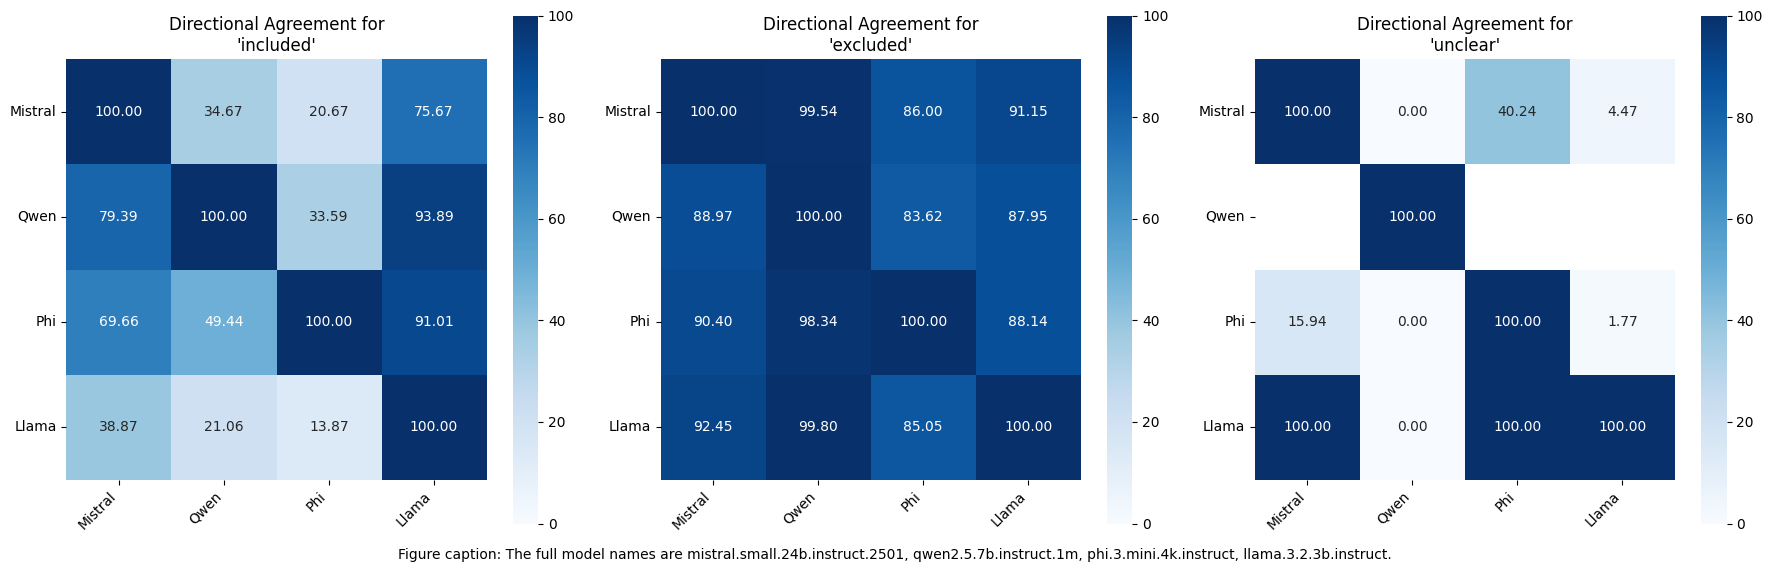

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Full model names for internal columns and display mapping for shortened names
full_model_names = {
    "mistral.small.24b.instruct.2501_inclusion": "mistral.small.24b.instruct.2501",
    "qwen2.5.7b.instruct.1m_inclusion": "qwen2.5.7b.instruct.1m",
    "phi.3.mini.4k.instruct_inclusion": "phi.3.mini.4k.instruct",
    "llama.3.2.3b.instruct_inclusion": "llama.3.2.3b.instruct"
}

display_names = {
    "mistral.small.24b.instruct.2501_inclusion": "Mistral",
    "qwen2.5.7b.instruct.1m_inclusion": "Qwen",
    "phi.3.mini.4k.instruct_inclusion": "Phi",
    "llama.3.2.3b.instruct_inclusion": "Llama"
}

# List of model keys to use
models = list(full_model_names.keys())

# Normalize the data: convert to string, remove extra spaces, and convert to lowercase
df[models] = df[models].astype(str).apply(lambda x: x.str.strip().str.lower())

# Define the categories (in lowercase)
categories = ["included", "excluded", "unclear"]

# Create a figure with 1 row and 3 columns for the three heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, cat in zip(axes, categories):
    # Initialize the agreement matrix for the category 'cat'
    agreement_matrix = pd.DataFrame(np.zeros((len(models), len(models))),
                                    index=models, columns=models)
    
    for i, model_a in enumerate(models):
        # Denom: number of cases where the row model assigns the category 'cat'
        denom = (df[model_a] == cat).sum()
        for j, model_b in enumerate(models):
            if model_a == model_b:
                agreement_matrix.loc[model_a, model_b] = 100.0
            else:
                # Numerator: number of cases where both models assign 'cat'
                numer = ((df[model_a] == cat) & (df[model_b] == cat)).sum()
                agreement_matrix.loc[model_a, model_b] = (numer / denom * 100) if denom > 0 else np.nan

    # Create the heatmap with the same color scale for all (from 0 to 100)
    sns.heatmap(agreement_matrix, annot=True, cmap="Blues", fmt=".2f",
                square=True, vmin=0, vmax=100, ax=ax)
    # Update tick labels to use display names
    ax.set_xticklabels([display_names[m] for m in models], rotation=45, ha="right")
    ax.set_yticklabels([display_names[m] for m in models], rotation=0)
    # Set title on two lines: first line "Directional Agreement for", second line the category
    ax.set_title(f"Directional Agreement for\n'{cat}'")

# Adjust layout to leave space for the caption
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Add a figure caption below the subplots
caption_text = ("Figure caption: The full model names are "
                "mistral.small.24b.instruct.2501, qwen2.5.7b.instruct.1m, "
                "phi.3.mini.4k.instruct, llama.3.2.3b.instruct.")
plt.figtext(0.5, 0.01, caption_text, ha="center", fontsize=10)

plt.show()


Figure X shows three directional agreement heatmaps comparing the classification outcomes of four models (Mistral, Qwen, Phi, and Llama) across the categories *included*, *excluded*, and *unclear*. Each cell (row = Model A, column = Model B) indicates the percentage of articles that both models assign to a given category, calculated relative to the total number of articles classified into that category by the reference (row) model. Because each row model determines its own denominator, the matrices are not symmetric, and “A vs. B” can differ substantially from “B vs. A.”

In the *included* category, from Mistral’s perspective, 34.67% of its included articles overlap with Qwen’s, 20.67% overlap with Phi’s, and 75.67% overlap with Llama’s. Qwen, by contrast, sees that 79.39% of its included articles match Mistral’s, while 93.89% match Llama’s. Phi finds that 91.01% of its included articles coincide with Llama’s, yet only 49.44% coincide with Qwen’s. Llama, meanwhile, shares 38.87% of its included set with Mistral, 21.06% with Qwen, and 13.87% with Phi. Shifting to the columns underscores similar asymmetries: for instance, Llama includes 93.89% of Qwen’s included articles but just 13.87% of Phi’s.

For the *excluded* articles, Mistral sees that 99.54% of its excluded articles overlap with Qwen’s, 86.00% overlap with Phi’s, and 91.15% overlap with Llama’s. Qwen, in turn, observes that 99.80% of its excluded articles match Llama’s. Phi reports 98.34% overlap with Qwen, while Llama sees 92.45% overlap with Mistral and 85.05% with Phi. When reversing the perspective, Qwen excludes 99.54% of Mistral’s and 99.80% of Llama’s excluded articles, demonstrating a strong consensus with both.

For the *unclear* subset, Mistral finds 0.00% overlap with Qwen, 40.24% with Phi, and 4.47% with Llama in its unclear assignments. Qwen sees no overlap (0.00%) with any of the other three models. Phi observes 15.94% overlap with Mistral but 0.00% with Qwen. Llama detects that 100.00% of its unclear articles match Mistral’s, yet none match Qwen’s or Phi’s. These large discrepancies persist when viewed from the columns, reflecting how differently the “unclear” label is applied across models.

Overall, the four models show notable asymmetries in both included and unclear decisions, largely due to differences in how many articles each model places in each category. Exclusion exhibits stronger overlap, particularly between Qwen and the other models, although smaller discrepancies remain. The “unclear” category displays the least agreement, suggesting distinct labeling thresholds among the models.